In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras

from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from keras import Input, Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


Read Data
* Data Source: [Trip Advisor Hotel Review](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) 

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',engine='python')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.shape

(20491, 2)

In [4]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [5]:
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library



In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

In [8]:
df['Review'] = df['Review'].apply(preprocess)


Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.



In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [10]:
NWORDS = 10000
tknz = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz.fit_on_texts(X_train)

train_seq = tknz.texts_to_sequences(X_train)
test_seq = tknz.texts_to_sequences(X_test)

In [11]:
print(len(tknz.word_index))

44178


Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [12]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq)))+1
MAX_SEQ_LEN

1941

In [13]:
pad_train_seq = pad_sequences(train_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq = pad_sequences(test_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


Build Models & Performance Evaluation

*   Bidirectional GRU
*   Bidirectional LSTM
*   SimpleRNN
*   Neural Network


In [14]:
EMBED_DIM = 32
BATCH_SIZE = 500
EPOCH = 30

In [15]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [16]:
def build_BiGRU(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model

In [17]:
def fit_model(model, model_name):
  history = model.fit(pad_train_seq,y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_accuracy',
                            patience=3,
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [18]:
def plot_PM(history):
  fig = px.line(
    history.history, y = ['auc', 'val_auc','accuracy','val_accuracy'],
    labels={'index': 'Epoch', 'value': 'Accuracy/AUC Score'},
    width = 450, height = 400,
    
  )
  fig.update_layout(legend_title = "Metrics")
  fig.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1941, 32)          320000    
                                                                 
 dropout (Dropout)           (None, 1941, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1941, 64)         12672     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1941, 64)          0         
                                                                 
 flatten (Flatten)           (None, 124224)            0         
                                                                 
 dense (Dense)               (None, 1)                 124225    
                                                       

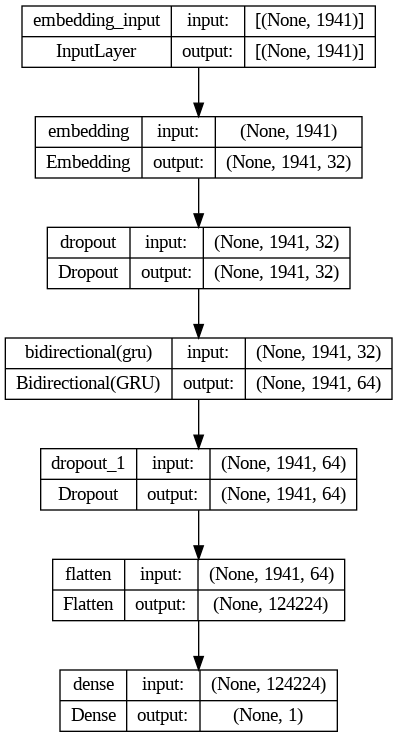

In [19]:
grumodel = build_BiGRU(EMBED_DIM)
show_model_summary(grumodel)
plot_model(grumodel,show_shapes=True)

Model Training and Model Evaluation

In [20]:
gruhistory = fit_model(grumodel,'./saved_model/grumodel1.h5')
plot_PM(gruhistory)
gru_results = grumodel.evaluate(pad_test_seq,y_test)
gru_results

Epoch 1/30
27/27 [==============================] - 200s 7s/step - loss: 0.5978 - accuracy: 0.7112 - auc: 0.5255 - val_loss: 0.5368 - val_accuracy: 0.7508 - val_auc: 0.7338
Epoch 2/30
27/27 [==============================] - 188s 7s/step - loss: 0.4821 - accuracy: 0.7653 - auc: 0.8373 - val_loss: 0.3336 - val_accuracy: 0.8683 - val_auc: 0.9263
Epoch 3/30
27/27 [==============================] - 188s 7s/step - loss: 0.2713 - accuracy: 0.8935 - auc: 0.9370 - val_loss: 0.2326 - val_accuracy: 0.9061 - val_auc: 0.9534
Epoch 4/30
27/27 [==============================] - 188s 7s/step - loss: 0.1961 - accuracy: 0.9216 - auc: 0.9676 - val_loss: 0.2201 - val_accuracy: 0.9116 - val_auc: 0.9577
Epoch 5/30
27/27 [==============================] - 190s 7s/step - loss: 0.1596 - accuracy: 0.9384 - auc: 0.9779 - val_loss: 0.2275 - val_accuracy: 0.9131 - val_auc: 0.9567
Epoch 6/30
27/27 [==============================] - 190s 7s/step - loss: 0.1296 - accuracy: 0.9536 - auc: 0.9844 - val_loss: 0.2261 - v

129/129 [==============================] - 28s 216ms/step - loss: 0.2896 - accuracy: 0.8988 - auc: 0.9373


[0.2895500361919403, 0.8987557888031006, 0.9373428225517273]

In [21]:
def build_LSTM(embedding_dim):
  model=Sequential()
  model.add(Embedding(NWORDS,embedding_dim,input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(32,return_sequences=True,recurrent_dropout=0.2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_2 (Dropout)         (None, 1941, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1941, 64)         16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1941, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 124224)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 124225    
                                                     

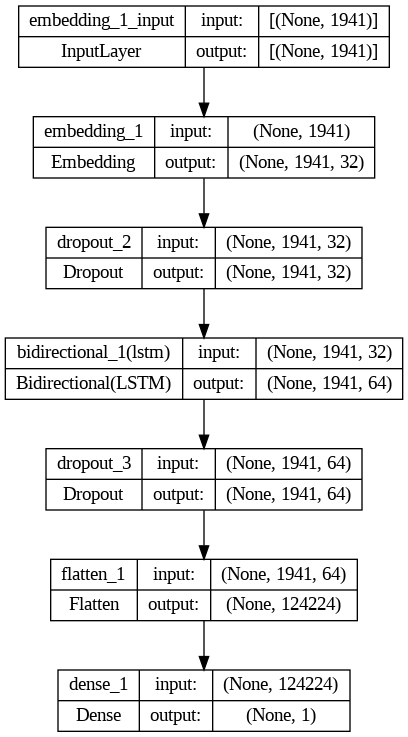

In [22]:
lstmmodel = build_LSTM(EMBED_DIM)
show_model_summary(lstmmodel)
plot_model(lstmmodel,show_shapes=True)

In [23]:
lstmhistory = fit_model(lstmmodel,'./saved_model/lsmtmodel1.h5')
plot_PM(lstmhistory)
lstm_results = lstmmodel.evaluate(pad_test_seq,y_test)
lstm_results 

Epoch 1/30
27/27 [==============================] - 283s 10s/step - loss: 0.5849 - accuracy: 0.7228 - auc: 0.5517 - val_loss: 0.5307 - val_accuracy: 0.7511 - val_auc: 0.7833
Epoch 2/30
27/27 [==============================] - 276s 10s/step - loss: 0.4284 - accuracy: 0.7982 - auc: 0.8549 - val_loss: 0.2752 - val_accuracy: 0.8927 - val_auc: 0.9337
Epoch 3/30
27/27 [==============================] - 275s 10s/step - loss: 0.2427 - accuracy: 0.9052 - auc: 0.9504 - val_loss: 0.2235 - val_accuracy: 0.9094 - val_auc: 0.9577
Epoch 4/30
27/27 [==============================] - 275s 10s/step - loss: 0.1843 - accuracy: 0.9268 - auc: 0.9714 - val_loss: 0.2194 - val_accuracy: 0.9149 - val_auc: 0.9579
Epoch 5/30
27/27 [==============================] - 274s 10s/step - loss: 0.1487 - accuracy: 0.9437 - auc: 0.9808 - val_loss: 0.2281 - val_accuracy: 0.9128 - val_auc: 0.9543
Epoch 6/30
27/27 [==============================] - 274s 10s/step - loss: 0.1241 - accuracy: 0.9537 - auc: 0.9863 - val_loss: 0.23

129/129 [==============================] - 43s 336ms/step - loss: 0.2753 - accuracy: 0.8939 - auc: 0.9407


[0.27530795335769653, 0.8938765525817871, 0.940651535987854]

In [24]:
def build_RNN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(SimpleRNN(32, activation='relu',name="RNN_Layer"))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid', name="Output"))

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  
  return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_4 (Dropout)         (None, 1941, 32)          0         
                                                                 
 RNN_Layer (SimpleRNN)       (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-t

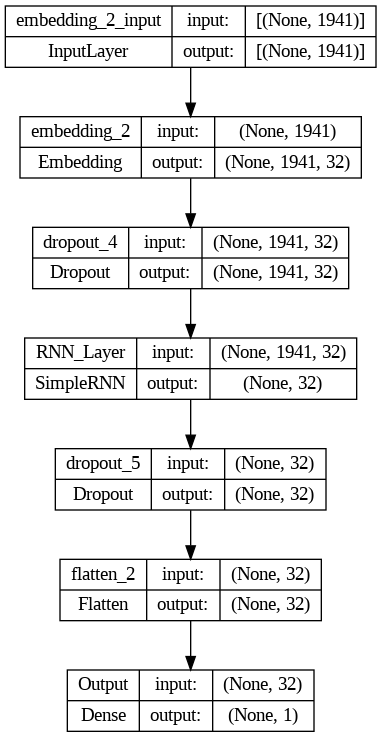

In [25]:
rnnmodel = build_RNN(EMBED_DIM)

show_model_summary(rnnmodel)
plot_model(rnnmodel,show_shapes=True)

In [26]:
rnnhistory = fit_model(rnnmodel,'./saved_model/rnnmodel1.h5')
plot_PM(rnnhistory)
rnn_results = rnnmodel.evaluate(pad_test_seq,y_test)
rnn_results 

Epoch 1/30
27/27 [==============================] - 40s 1s/step - loss: 0.6133 - accuracy: 0.7293 - auc: 0.5068 - val_loss: 0.5718 - val_accuracy: 0.7511 - val_auc: 0.5000
Epoch 2/30
27/27 [==============================] - 38s 1s/step - loss: 0.5888 - accuracy: 0.7328 - auc: 0.4954 - val_loss: 0.5654 - val_accuracy: 0.7511 - val_auc: 0.5000
Epoch 3/30
27/27 [==============================] - 37s 1s/step - loss: 0.5871 - accuracy: 0.7329 - auc: 0.4950 - val_loss: 0.5661 - val_accuracy: 0.7511 - val_auc: 0.5000
Epoch 4/30
27/27 [==============================] - 38s 1s/step - loss: 0.5855 - accuracy: 0.7329 - auc: 0.5018 - val_loss: 0.5615 - val_accuracy: 0.7511 - val_auc: 0.5000
       loss  accuracy       auc  val_loss  val_accuracy  val_auc
0  0.613253  0.729276  0.506827  0.571788      0.751144      0.5
1  0.588766  0.732784  0.495395  0.565380      0.751144      0.5
2  0.587063  0.732861  0.495046  0.566123      0.751144      0.5
3  0.585506  0.732937  0.501752  0.561484      0.751

129/129 [==============================] - 10s 80ms/step - loss: 0.5831 - accuracy: 0.7365 - auc: 0.5000


[0.5831193327903748, 0.7365211248397827, 0.5]

In [27]:
def build_NN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN
                      ))
  model.add(Dropout(0.5))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.25))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])


  return model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1941, 32)          320000    
                                                                 
 dropout_6 (Dropout)         (None, 1941, 32)          0         
                                                                 
 dense_2 (Dense)             (None, 1941, 32)          1056      
                                                                 
 dropout_7 (Dropout)         (None, 1941, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                     

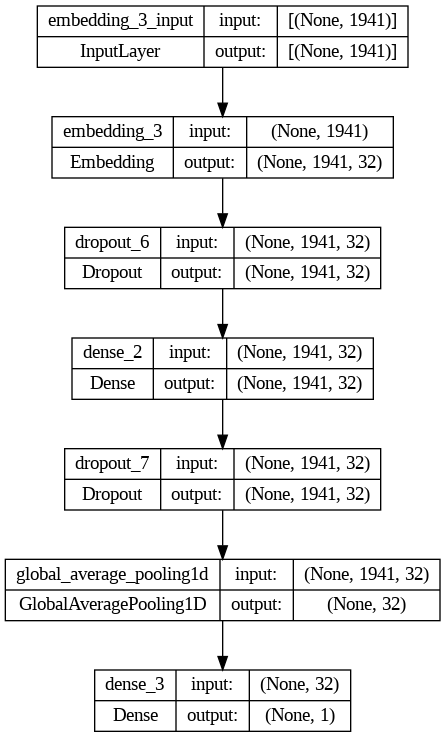

In [28]:
nnmodel = build_NN(EMBED_DIM)
show_model_summary(nnmodel)
plot_model(nnmodel,show_shapes=True)

In [29]:
nnhistory = fit_model(nnmodel,'./saved_model/nnmodel1.h5')
plot_PM(nnhistory)
nn_restuls = nnmodel.evaluate(pad_test_seq,y_test)
nn_restuls

Epoch 1/30
27/27 [==============================] - 27s 944ms/step - loss: 0.6618 - accuracy: 0.7329 - auc: 0.5022 - val_loss: 0.6224 - val_accuracy: 0.7511 - val_auc: 0.5578
Epoch 2/30
27/27 [==============================] - 25s 918ms/step - loss: 0.6019 - accuracy: 0.7329 - auc: 0.5098 - val_loss: 0.5657 - val_accuracy: 0.7511 - val_auc: 0.5889
Epoch 3/30
27/27 [==============================] - 25s 927ms/step - loss: 0.5791 - accuracy: 0.7329 - auc: 0.5361 - val_loss: 0.5592 - val_accuracy: 0.7511 - val_auc: 0.6136
Epoch 4/30
27/27 [==============================] - 25s 940ms/step - loss: 0.5788 - accuracy: 0.7329 - auc: 0.5587 - val_loss: 0.5596 - val_accuracy: 0.7511 - val_auc: 0.6202
       loss  accuracy       auc  val_loss  val_accuracy   val_auc
0  0.661842  0.732937  0.502160  0.622352      0.751144  0.557777
1  0.601928  0.732937  0.509819  0.565740      0.751144  0.588899
2  0.579085  0.732937  0.536073  0.559172      0.751144  0.613588
3  0.578833  0.732937  0.558686  0.5

129/129 [==============================] - 1s 10ms/step - loss: 0.6273 - accuracy: 0.7365 - auc: 0.5523


[0.627281129360199, 0.7365211248397827, 0.5523494482040405]

# Test Data - Performance Evaluation Summary 

* Bidirectional GRU achieves best Accuracy Score whereas Bidirectional LSTM achievs best AUC score.  Both models have better performance with the expense of computing time complexity.  

In [31]:
print("Bidirectional GRU: ", gru_results)
print("Bidirectional LSTM: ", lstm_results)
print("SimpleRNN: ", rnn_results)
print("Neural Network: ", nn_restuls)

Bidirectional GRU:  [0.2895500361919403, 0.8987557888031006, 0.9373428225517273]
Bidirectional LSTM:  [0.27530795335769653, 0.8938765525817871, 0.940651535987854]
SimpleRNN:  [0.5831193327903748, 0.7365211248397827, 0.5]
Neural Network:  [0.627281129360199, 0.7365211248397827, 0.5523494482040405]
